<a href="https://colab.research.google.com/github/Esbern/conservation-agriculture/blob/main/Calculate_ndvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing NDVI for Conservation and non conservation agricultur

## Defining the Problem
We have 8 fields comparison plots with a Conversational and a non conversational agricultural field neighbouring each other. Of these 1 is a  pilot (nr 7) which consists of small subplots with in a larger field is excludes from the NDVI calculation since the subplots are too small to isolate on the landsat image. For

## Overall workflow
1. Setup the GEE work environment
2. Load the fields from Github
3. Extract the Landsat data for the given areas and period
4. Identify which pixels are within which fields/treatments (Intersect)
5. Process the pixels (Decode quality byte, convert the time stamp to Year, Month Day)
6. Join filed/treatment data to the pixels
7. Filter pixels for clouds
8. Calculate the average NDVI for each Year, Month for each field/treatment

## Processing

### Setup the environment

In [2]:
import ee
import numpy as np
import geemap
import os
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


In [6]:
ee.Authenticate()

In [7]:
ee.Initialize(project="ee-holmes-e23")

If the machine is a new one copy the gee credentials

In [8]:
geemap.ee_initialize()

### Load Data
Load a geojson document that defines the field and treatment type for each pixel

In [9]:
fields = gpd.read_file("https://raw.githubusercontent.com/Esbern/conservation-agriculture/main/sampel_fields.geojson")

In [10]:
attribute_to_color = {
    'CT': '#FF0000',  # Red
    'MT': '#00FF00',  # Green
}
fields['color'] = fields['tillage'].map(attribute_to_color)
Map = geemap.Map(center=(55, 13), zoom=4)
Map.add_gdf(fields, layer_name="Fields",
            style_callback=lambda x: {'fillColor': x['properties']['color']})
Map

Map(center=[55, 13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

### Extract the Landsat data for the given areas and period

In [11]:
# Convert Dataframe to ee object
fields_ee = geemap.geopandas_to_ee(fields)

In [12]:
# Identify Landsat images covering the fields for the given priod
L7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_TOA")
col = L7 \
  .filterBounds(fields_ee) \
  .filterDate('2010-01-01', '2016-01-01') \
  .select('B3','B4','QA_PIXEL')
count = col.size()
count


In [13]:
# Collect the pixel values and convert them to a local dataframe

pixelInfoBbox= col.getRegion(geometry=fields_ee,scale=30)
pixelList = pixelInfoBbox.getInfo()
all_pixels_df = pd.DataFrame(pixelList[1:], columns=pixelList[0])

### Identify which pixels are within which fields/treatments (Intersect)


In [15]:
#Extract all unique pixel coordinates and convert them to a GeoPandas dataframe
pixel_df = all_pixels_df.groupby(['longitude', 'latitude']).size().reset_index(name='counts')
pixels_gdf = gpd.GeoDataFrame(
    pixel_df, geometry=gpd.points_from_xy(pixel_df.longitude, pixel_df.latitude), crs="EPSG:4326"
)
pixel_fields_gdf = gpd.overlay( pixels_gdf,fields, how='intersection')

In [16]:
def style_function(feature):
    return {
        'color': feature['properties']['color'],  # This sets the border color
        'fillColor': feature['properties']['color'],  # This sets the fill color
        'fillOpacity': 0.5,
        'weight': 1,
    }

Map = geemap.Map(center=(55, 13), zoom=4)
Map.add_gdf(fields, layer_name="Fields",
            style_callback=lambda x: {'fillColor': x['properties']['color']})
Map.add_gdf(pixel_fields_gdf, layer_name="pixels")

Map

Map(center=[55, 13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

### Process the pixels (Caclulate NDVIFilter pixels for clouds and convert the time stamp to Year, Month Day)

In [17]:
#Process Time and NDVI
all_pixels_df['time'] = pd.to_datetime(all_pixels_df['time'], unit='ms')

# Extract year, month, and day to separate columns
all_pixels_df['year'] = all_pixels_df['time'].dt.year
all_pixels_df['month'] = all_pixels_df['time'].dt.month
all_pixels_df['day'] = all_pixels_df['time'].dt.day

# Calculate NDVI and add it as a new column
all_pixels_df['NDVI'] = (all_pixels_df['B4'] - all_pixels_df['B3']) / (all_pixels_df['B4'] + all_pixels_df['B3'])

# Handle potential division by zero or NaN values
all_pixels_df['NDVI'] = all_pixels_df['NDVI'].replace([np.inf, -np.inf], np.nan)



In [18]:
# Function to decode the QA_PIXEL column, modified to handle NaN values
def decode_qa_pixel(value):
    # Check if the value is NaN and return NaN for all attributes if true
    if pd.isna(value):
        return pd.Series([np.nan] * 11, index=[
            'Fill', 'Dilated Cloud', 'Cloud', 'Cloud Shadow', 'Snow',
            'Clear', 'Water', 'Cloud Confidence', 'Cloud Shadow Confidence',
            'Snow/Ice Confidence', 'Cirrus Confidence'])

    # Convert float to int and then to binary string, stripping the '0b' prefix
    binary_str = format(int(value), '016b')

    # Decode each bit based on the descriptions provided
    attributes = {
        'Fill': 'Fill data' if binary_str[-1] == '1' else 'Image data',
        'Dilated Cloud': 'Cloud dilation' if binary_str[-2] == '1' else 'Cloud is not dilated or no cloud',
        'Cloud': 'High confidence cloud' if binary_str[-4] == '1' else 'Cloud confidence is not high',
        'Cloud Shadow': 'High confidence cloud shadow' if binary_str[-5] == '1' else ' Cloud Shadow Confidence is not high',
        'Snow': 'High confidence snow cover' if binary_str[-6] == '1' else 'Snow/Ice Confidence is not high',
        'Clear': 'Cloud and Dilated Cloud bits not set' if binary_str[-7] == '1' else 'Cloud or Dilated Cloud bits set',
        'Water': 'Water' if binary_str[-8] == '1' else 'Land or cloud',
        'Cloud Confidence': {
            '00': 'No cloud confidence level set',
            '01': 'Low cloud confidence',
            '10': 'Medium cloud confidence',
            '11': 'High cloud confidence',
        }[binary_str[-10:-8]],
        'Cloud Shadow Confidence': {
            '00': 'No cloud shadow confidence level set',
            '01': 'Low cloud shadow confidence',
            '10': 'Reserved',
            '11': 'High cloud shadow confidence',
        }[binary_str[-12:-10]],
        'Snow/Ice Confidence': {
            '00': 'No snow/ice confidence level set',
            '01': 'Low snow/ice confidence',
            '10': 'Reserved',
            '11': 'High snow/ice confidence',
        }[binary_str[-14:-12]],
        'Cirrus Confidence': {
            '00': 'No cirrus confidence level set',
            '01': 'Low cirrus confidence',
            '10': 'Reserved',
            '11': 'High cirrus confidence',
        }[binary_str[-16:-14]],
    }

    return pd.Series(attributes)

# Apply the decode function to the QA_PIXEL column and assign the result to new columns
new_columns = all_pixels_df['QA_PIXEL'].apply(decode_qa_pixel)
all_pixels_df = pd.concat([all_pixels_df, new_columns], axis=1)



### Join filed/treatment data to the pixels


In [ ]:
merged_df = pd.merge(all_pixels_df, pixel_fields_gdf[['longitude', 'latitude', 'pair', 'tillage']], on=['longitude', 'latitude'], how='left')

### Filter pixels for clouds

In [ ]:
filtered_df = merged_df[merged_df['Clear'] == "Cloud and Dilated Cloud bits not set"]

In [ ]:
merged_df.to_csv("/content/drive/MyDrive/Conservation_agri/pixl_data.csv", index=False)

NameError: name 'merged_df' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filtered_df.to_excel("/content/drive/MyDrive/Conservation_agri/pixler.xlsx", index=False)

## If you just need the plots

In [ ]:
filtered_df = pd.read_excel("/content/drive/MyDrive/Conservation_agri/pixler.xlsx")

## Start plotting

Add climat referance value

In [ ]:
# Data preparation
climat_data = {
    "Month": ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    "Average of Maximum Temperature": [3.8, 4, 6.9, 11.6, 16.1, 19.1, 21.1, 21.2, 17.5, 12.8, 8.3, 6],
    "Average Temperature": [1.9, 1.8, 3.7, 7.4, 11.7, 14.9, 16.7, 16.8, 13.9, 10.1, 6.3, 4.2],
    "Average of Minimum Temperature": [-0.3, -0.6, 0.8, 3.4, 7.3, 10.6, 12.3, 12.7, 10.4, 7.4, 3.9, 2],
    "Total Precipitation": [66, 49.3, 43.1, 37.7, 47.4, 66.9, 69.5, 86.1, 82.6, 84.5, 67.4, 81.2]
}

In [ ]:

# --- ANOVA to test differences between groups (This part remains the same) ---
anova_series = filtered_df.groupby(['month']).apply(
    lambda x: stats.f_oneway(x[x['tillage'] == 'MT']['NDVI'], x[x['tillage'] == 'CT']['NDVI'])
)
anova_results = pd.DataFrame(anova_series.tolist(), index=anova_series.index, columns=['F-Statistic', 'p-Value'])
anova_results['Significant'] = anova_results['p-Value'] < 0.05

print("ANOVA Results:")
print(anova_results)




# 1. Use .agg() to get the mean, count (n), and standard deviation for each group.
summary_stats = filtered_df.groupby(['month', 'tillage'])['NDVI'].agg(
    Mean='mean',
    Count='count',  # 'count' provides the number of observations (n)
    Std_Dev='std'
).reset_index()

# 2. Calculate the Standard Error of the Mean (SEM).
# SEM = Standard Deviation / sqrt(Number of Observations)
summary_stats['Std_Error'] = summary_stats['Std_Dev'] / np.sqrt(summary_stats['Count'])

# 3. Calculate the 95% confidence interval bounds.
# The z-score for 95% confidence is ~1.96. stats.norm.ppf(0.975) gives the precise value.
z_score = stats.norm.ppf(0.975)
summary_stats['CI_Lower'] = summary_stats['Mean'] - z_score * summary_stats['Std_Error']
summary_stats['CI_Upper'] = summary_stats['Mean'] + z_score * summary_stats['Std_Error']


# 4. Display the final, comprehensive table.
print("\nSummary Statistics and Confidence Intervals:")
# We select the columns we care most about for the final printout.
print(summary_stats[['month', 'tillage', 'Mean', 'Count', 'CI_Lower', 'CI_Upper']])

ANOVA Results:
       F-Statistic       p-Value  Significant
month                                        
2         2.600094  1.072764e-01        False
3        45.648983  1.887977e-11         True
4        46.982424  9.501919e-12         True
5         7.809740  5.228945e-03         True
6        80.200740  6.355013e-19         True
7         1.561691  2.114905e-01        False
8        45.105553  2.224434e-11         True
9         2.723922  9.901826e-02        False
10       39.922835  3.272754e-10         True
11        9.909460  1.801685e-03         True

Summary Statistics and Confidence Intervals:
    month tillage      Mean  Count  CI_Lower  CI_Upper
0       2      CT  0.329519    291  0.313797  0.345242
1       2      MT  0.315630    464  0.306600  0.324661
2       3      CT  0.376576    827  0.365653  0.387499
3       3      MT  0.331621   1028  0.323900  0.339342
4       4      CT  0.360876    842  0.348780  0.372972
5       4      MT  0.418942   1164  0.407858  0.430026
6 

/tmp/ipython-input-3023922054.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  anova_series = filtered_df.groupby(['month']).apply(


/tmp/ipython-input-3976450987.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box_plot.set_xticklabels([month_names[int(tick.get_text())] for tick in box_plot.get_xticklabels()])


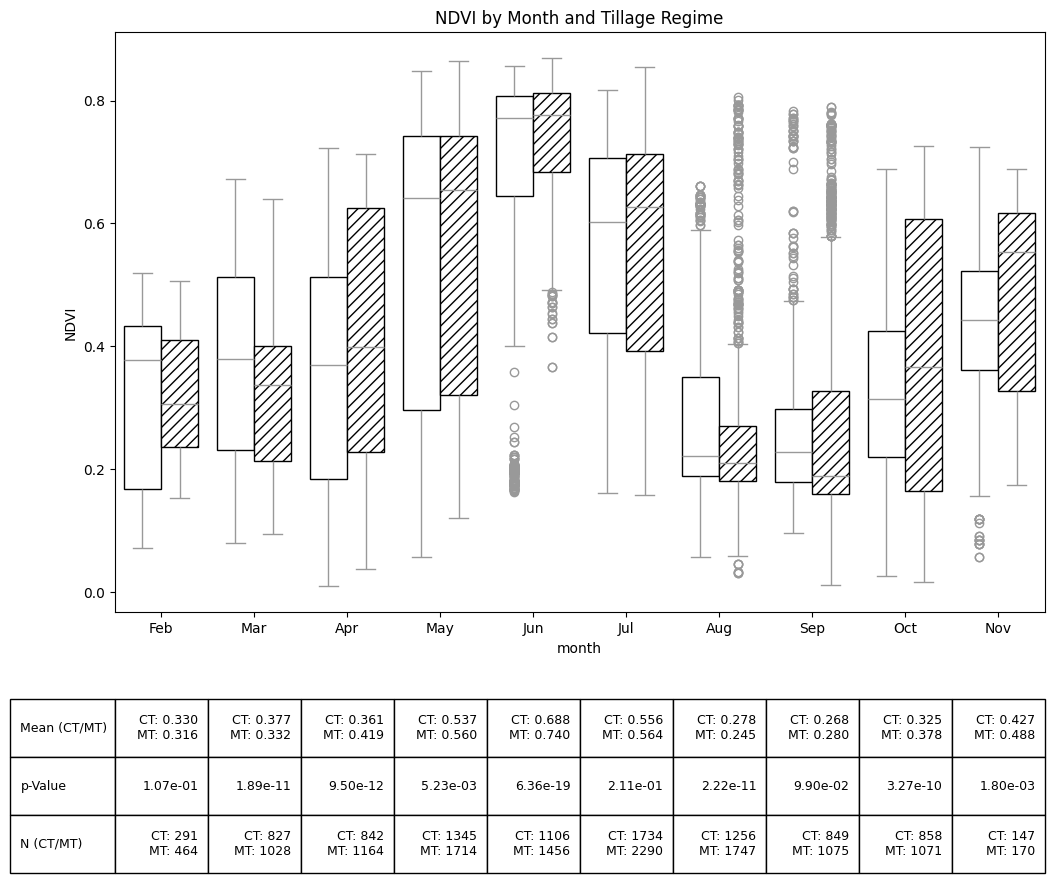

In [ ]:

fig, ax = plt.subplots(figsize=(12, 10))
box_plot = sns.boxplot(x='month', y='NDVI', hue='tillage', data=filtered_df, palette=['white', 'white'])
plt.title('NDVI by Month and Tillage Regime')
hue_order = box_plot.get_legend_handles_labels()[1]
num_months = len(filtered_df['month'].unique())
month_names = {2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov"}
box_plot.set_xticklabels([month_names[int(tick.get_text())] for tick in box_plot.get_xticklabels()])

for i, patch in enumerate(box_plot.patches):
    hue_index = (i // num_months) % len(hue_order)
    tillage_type = hue_order[hue_index]
    if tillage_type == 'MT':
        patch.set_hatch('///')
        patch.set_edgecolor('black')
    else:
        patch.set_edgecolor('black')
box_plot.legend_.remove()


# 1. Prepare the data for all three table rows
p_values = ['{:.2e}'.format(p) for p in anova_results['p-Value']]

# Create the NEW row for Mean values, formatted to 3 decimal places
mean_values = []
sorted_months = sorted(filtered_df['month'].unique())
for month in sorted_months:
    ct_mean = summary_stats.loc[(summary_stats['month'] == month) & (summary_stats['tillage'] == 'CT'), 'Mean'].iloc[0]
    mt_mean = summary_stats.loc[(summary_stats['month'] == month) & (summary_stats['tillage'] == 'MT'), 'Mean'].iloc[0]
    mean_values.append(f"CT: {ct_mean:.3f}\nMT: {mt_mean:.3f}")

# Create the row for the number of observations (N)
n_counts = []
for month in sorted_months:
    ct_count = summary_stats.loc[(summary_stats['month'] == month) & (summary_stats['tillage'] == 'CT'), 'Count'].iloc[0]
    mt_count = summary_stats.loc[(summary_stats['month'] == month) & (summary_stats['tillage'] == 'MT'), 'Count'].iloc[0]
    n_counts.append(f"CT: {ct_count}\nMT: {mt_count}")

# 2. Update the cellText and rowLabels to use the new Mean row
table_data = [mean_values, p_values, n_counts]
row_labels = ['Mean (CT/MT)', 'p-Value', 'N (CT/MT)']

# 3. Add the table with the updated rows
the_table = ax.table(cellText=table_data,
                     rowLabels=row_labels,
                     loc='bottom',
                     bbox=[0.0, -0.45, 1.0, 0.3])

# 4. Adjust font size and row height
the_table.auto_set_font_size(False)
the_table.set_fontsize(9)
the_table.scale(1, 1.0)

# 5. Adjust overall plot layout to make space for the table
plt.subplots_adjust(bottom=0.3)

# Show and save the plot
plt.show()
fig.savefig('till_NDVI.png', dpi=300, bbox_inches='tight')

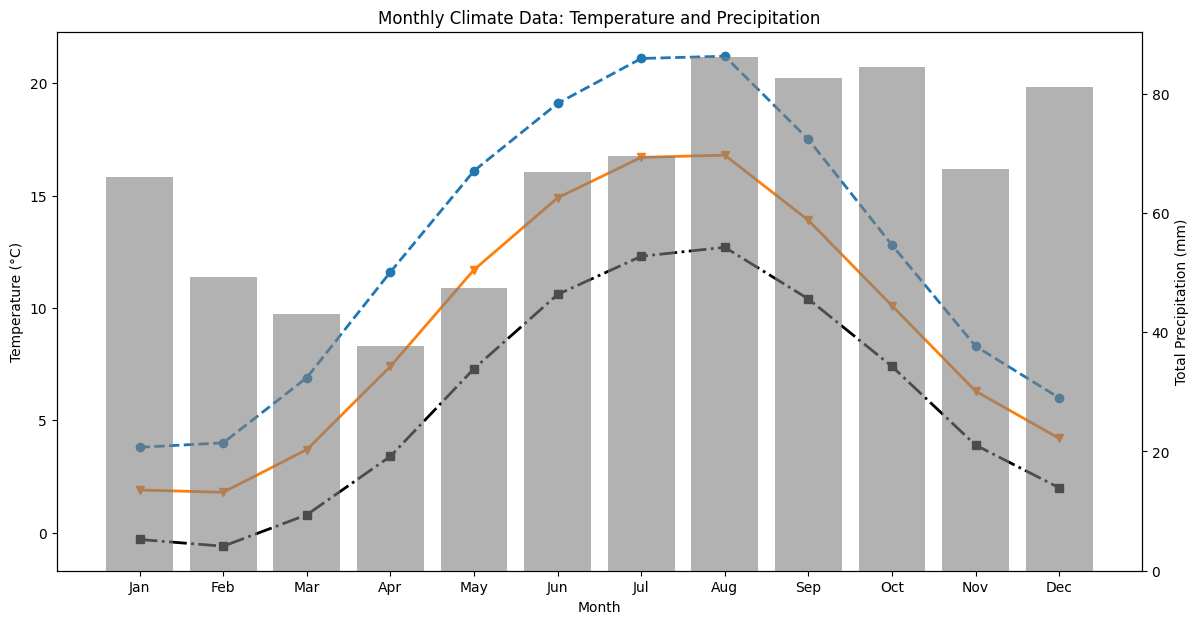

In [ ]:
df = pd.DataFrame(climat_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Temperature plot (line)
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°C)')
ax1.plot(df['Month'], df['Average of Maximum Temperature'], linestyle='--', linewidth=2, label='Avg of Max Temp', marker='o')
ax1.plot(df['Month'], df['Average Temperature'], linestyle='-', linewidth=2, label='Avg Temp', marker='v')
ax1.plot(df['Month'], df['Average of Minimum Temperature'], color="black", linestyle='-.', linewidth=2, label='Avg of Min Temp', marker='s')
ax1.tick_params(axis='y')
#ax1.legend(loc='upper left')

# Precipitation plot (bar) using twin axis
ax2 = ax1.twinx()
ax2.set_ylabel('Total Precipitation (mm)')
ax2.bar(df['Month'], df['Total Precipitation'], color='grey', label='Total Precipitation', alpha=0.6)
ax2.tick_params(axis='y')
#ax2.legend(loc='upper right')

# Title
plt.title('Monthly Climate Data: Temperature and Precipitation')

plt.show()

# Save the plot in high resolution
fig.savefig('climate_data_plot.png', dpi=300, bbox_inches='tight')